## Εισαγωγικά

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 

In [2]:
# Set random seed for reproducibility
import random
import os
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x1E8810AE540

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [4]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Keys in the dataset are formatted as such:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Keys in the dataset are formatted as such: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [5]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

# save the DataFrames to CSV files SO I DONT HAVE TO RELOAD THEM EVERY TIME
#df_train.to_csv('train_data.csv', index=False)
#df_val.to_csv('val_data.csv', index=False)
#df_test.to_csv('test_data.csv', index=False)

In [6]:
# Load data, IF YOU DONT WANT TO RELOAD THE DATA, COMMENT THIS OUT
df_train = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

Train images shape: (546, 50176)
Train labels shape: (546,)
Missing values in training data: 0

Validation images shape: (156, 50176)
Validation labels shape: (156,)
Missing values in validation data: 0

Test images shape: (78, 50176)
Test labels shape: (78,)
Missing values in test data: 0


Total number of images: 780, (546 (70.00%) train), (156 (20.00%) val), 78 (10.00)% test)
Number of positives: 399 train, 114 val, 57 test
Percentage of positives: 73.08% train, 73.08% val, 73.08% test
Number of negatives: 147 train, 42 val, 21 test
Percentage of negatives: 26.92% train, 26.92% val, 26.92% test


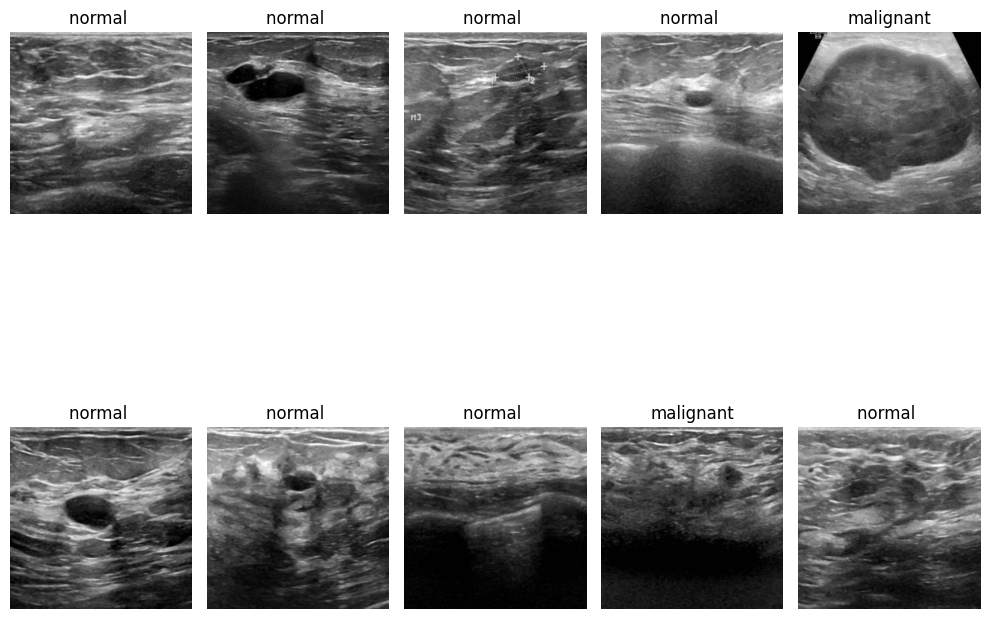

In [7]:

# Check the shapes of the arrays and DataFrames
print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Missing values in training data:", df_train.isnull().sum().sum())
print()
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Missing values in validation data:", df_val.isnull().sum().sum())
print()
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)
print("Missing values in test data:", df_test.isnull().sum().sum())

"""# Display the first few rows of each DataFrame
print("Training DataFrame:")
print(df_train.head())

print("Validation DataFrame:")
print(df_val.head())

print("Test DataFrame:")
print(df_test.head())
"""

print("\n")
# Calculate the total number of images
num_train = len(x_train)
num_val = len(x_val)
num_test = len(x_test)
total_images = num_train + num_val + num_test
print(f"Total number of images: {total_images}, ({num_train} ({num_train /total_images * 100:.2f}%) train), ({num_val} ({num_val/total_images * 100:.2f}%) val), {num_test} ({num_test/total_images * 100:.2f})% test)")
print(f"Number of positives: {np.sum(y_train == 1)} train, {np.sum(y_val == 1)} val, {np.sum(y_test == 1)} test")
print(f"Percentage of positives: {np.mean(y_train == 1) * 100:.2f}% train, {np.mean(y_val == 1) * 100:.2f}% val, {np.mean(y_test == 1) * 100:.2f}% test")
print(f"Number of negatives: {np.sum(y_train == 0)} train, {np.sum(y_val == 0)} val, {np.sum(y_test == 0)} test")
print(f"Percentage of negatives: {np.mean(y_train == 0) * 100:.2f}% train, {np.mean(y_val == 0) * 100:.2f}% val, {np.mean(y_test == 0) * 100:.2f}% test")


# Display the first X images

images = data['train_images']
labels = data['train_labels']

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for 10 images
    plt.imshow(images[i], cmap='gray')
    plt.title(f"{'normal ' if labels[i] == 1 else 'malignant'}")
    plt.axis('off')

plt.tight_layout()
plt.show()


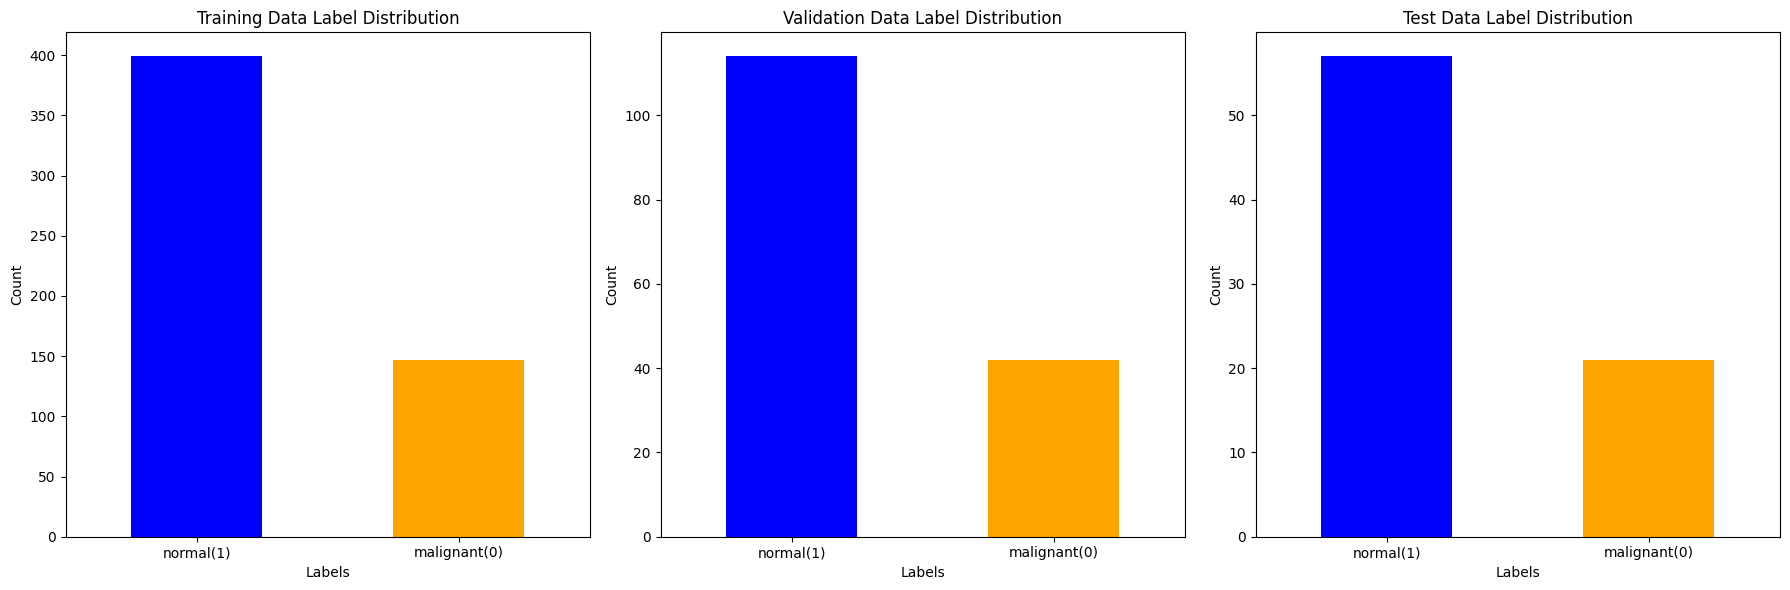

In [8]:
#PLOTS
# Convert the relevant data from the NpzFile object into a pandas DataFrame
# Create a row of 3 plots for the label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for training data
df_train['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Training Data Label Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels

# Plot for validation data
df_val['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Validation Data Label Distribution')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Plot for test data
df_test['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[2], color=['blue', 'orange'])
axes[2].set_title('Test Data Label Distribution')
axes[2].set_xlabel('Labels')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# Ισως να το σβήσω αυτό, δεν είναι απαραίτητο
# Find extreme values (min and max) in the image datasets

print("Extreme values in train_images:")
print("  Min:", np.min(data['train_images']))
print("  Max:", np.max(data['train_images']))

print("Extreme values in val_images:")
print("  Min:", np.min(data['val_images']))
print("  Max:", np.max(data['val_images']))

print("Extreme values in test_images:")
print("  Min:", np.min(data['test_images']))
print("  Max:", np.max(data['test_images']))

# For all images combined
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
print("Extreme values in all images:")
print("  Min:", np.min(all_images))
print("  Max:", np.max(all_images))

Extreme values in train_images:
  Min: 0
  Max: 255
Extreme values in val_images:
  Min: 0
  Max: 255
Extreme values in test_images:
  Min: 0
  Max: 255
Extreme values in all images:
  Min: 0
  Max: 255


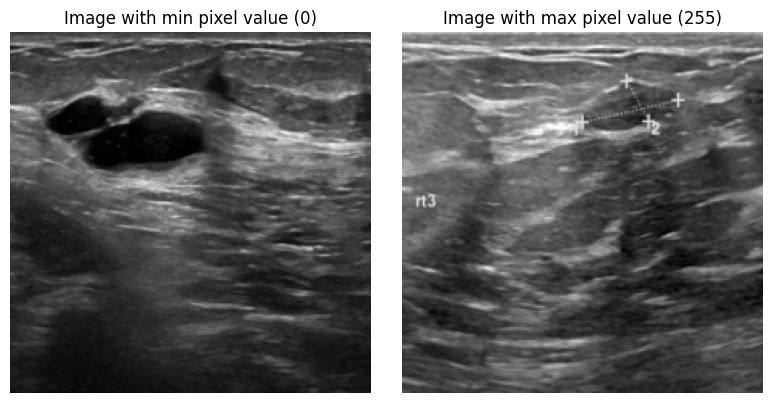

In [10]:
# Visualize images with extreme pixel values

# Find min and max pixel values in all images
min_val = np.min(all_images)
max_val = np.max(all_images)

# Find the indices of images containing the min and max values
min_img_idx = np.where(np.any(all_images == min_val, axis=(1,2)))[0][0]
max_img_idx = np.where(np.any(all_images == max_val, axis=(1,2)))[0][0]

# Show the image with the minimum pixel value
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(all_images[min_img_idx], cmap='gray')
plt.title(f'Image with min pixel value ({min_val})')
plt.axis('off')

# Show the image with the maximum pixel value
plt.subplot(1, 2, 2)
plt.imshow(all_images[max_img_idx], cmap='gray')
plt.title(f'Image with max pixel value ({max_val})')
plt.axis('off')

plt.tight_layout()
plt.show()

Number of outlier images (mean pixel value): 1


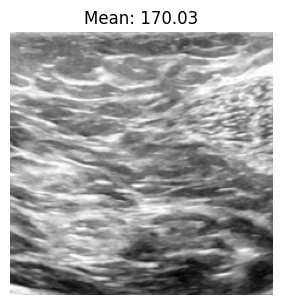

In [11]:
# Detect outlier images based on mean pixel value

# Compute mean pixel value for each image
image_means = all_images.reshape(all_images.shape[0], -1).mean(axis=1)

# Calculate thresholds for outliers (e.g., using 3 standard deviations from the mean)
mean_val = np.mean(image_means)
std_val = np.std(image_means)
lower_threshold = mean_val - 3 * std_val
upper_threshold = mean_val + 3 * std_val

# Find indices of outlier images
outlier_indices = np.where((image_means < lower_threshold) | (image_means > upper_threshold))[0]

print(f"Number of outlier images (mean pixel value): {len(outlier_indices)}")

# Optionally, visualize the outlier images
if len(outlier_indices) > 0:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(outlier_indices[:5]):  # Show up to 5 outliers
        plt.subplot(1, 5, i + 1)
        plt.imshow(all_images[idx], cmap='gray')
        plt.title(f"Mean: {image_means[idx]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No outlier images found.")

The outlier doesn't seem corrupted, I will keep it since it's just an image with very different brightness and that may be the cause for being considered an outlier

### 2. Προεπεξεργασία Δεδομένων

#### α. Χειρισμός ακραίων τιμών: δεν υπάρχουν ελλειπούσες τιμές και επιλέγω να διατηρήσω το outlier 

#### β. Κανονικοποίηση/Τυποποίηση χαρακτηριστικών: 
Για την κανονικοποίηση/τυποποίηση των χαρακτηριστικών, εφαρμόστηκε η μέθοδος Standard Scaling (Z-score normalization), ώστε κάθε χαρακτηριστικό να έχει μέση τιμή 0 και τυπική απόκλιση 1. Η επιλογή αυτή έγινε επειδή οι αλγόριθμοι PCA, LDA και Logistic Regression είναι ευαίσθητοι στην κλίμακα των χαρακτηριστικών. Η κατανομή των τιμών πριν και μετά την τυποποίηση απεικονίστηκε με ιστογράμματα, ενώ παρατηρήθηκε ότι η τυποποίηση βελτιώνει τη διακριτική ικανότητα και τη σύγκλιση των αλγορίθμων.

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_images_flat)
x_val_std = scaler.transform(val_images_flat)  
x_test_std = scaler.transform(test_images_flat)

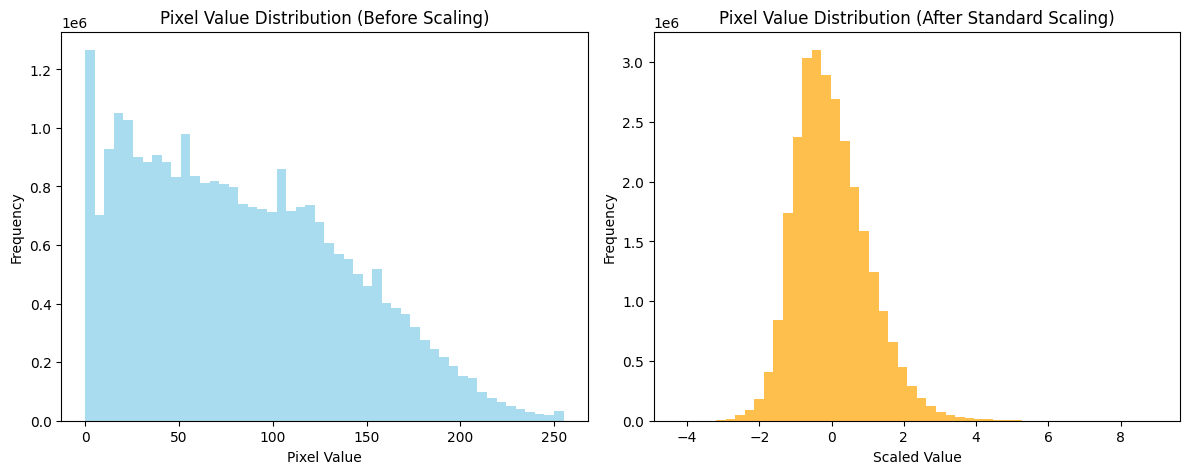

In [13]:
# Visualize pixel value distributions before and after Standard Scaling

# Flatten the training images
flattened_images = x_train.reshape(x_train.shape[0], -1)

# Before scaling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_images.flatten(), bins=50, color='skyblue', alpha=0.7)
plt.title('Pixel Value Distribution (Before Scaling)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# After scaling
flattened_images_std = scaler.fit_transform(flattened_images)
plt.subplot(1, 2, 2)
plt.hist(flattened_images_std.flatten(), bins=50, color='orange', alpha=0.7)
plt.title('Pixel Value Distribution (After Standard Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
print("Mean pixel value:", np.mean(data['train_images']))
print("Standard deviation of pixel values:", np.std(data['train_images']))

print("Mean pixel value after scaling:", np.mean(flattened_images_std))
print("Standard deviation of pixel values after scaling:", np.std(flattened_images_std))

Mean pixel value: 83.56028899154099
Standard deviation of pixel values: 55.95538071677974
Mean pixel value after scaling: 2.960428742496773e-17
Standard deviation of pixel values after scaling: 1.0


Ανάλυση επίδρασης:(το αναφέρω και πιο πάνω) scaling improves convergence and performance for most machine learning algorithms, especially those based on distances or projections.

#### γ. Επιλογή και μετασχηματισμός χαρακτηριστικών:

1. Αφαίρεση χαρακτηριστικών με χαμηλή διακύμανση (Remove low-variance features)
You can use VarianceThreshold from scikit-learn to remove features (pixels) with very low variance, which are unlikely to be useful for classification

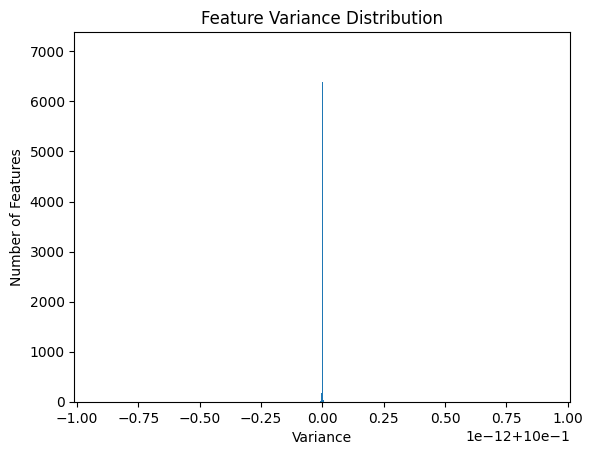

In [15]:
# Calculate variances
variances = x_train_std.var(axis=0)
plt.hist(variances, bins=50)
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Number of Features")
plt.show()

In [16]:
print("Min variance:", variances.min())
print("Max variance:", variances.max())

Min variance: 0.9999999999999898
Max variance: 1.0000000000000102


In [17]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
X_train_var = selector.fit_transform(x_train_std)
X_val_var = selector.transform(x_val_std)
X_test_var = selector.transform(x_test_std)

print("Original shape:", x_train_std.shape)
print("After variance thresholding:", X_train_var.shape)

Original shape: (546, 50176)
After variance thresholding: (546, 50176)


2. Δημιουργία νέων χαρακτηριστικών (Feature engineering)
For images, common new features include mean, standard deviation, or other statistics per image. Example:

In [18]:
# Example: Add mean and std of pixel values as new features
train_means = x_train.reshape(x_train.shape[0], -1).mean(axis=1).reshape(-1, 1)
train_stds = x_train.reshape(x_train.shape[0], -1).std(axis=1).reshape(-1, 1)
X_train_fe = np.hstack([X_train_var, train_means, train_stds])

# Repeat for validation and test sets
val_means = x_val.reshape(x_val.shape[0], -1).mean(axis=1).reshape(-1, 1)
val_stds = x_val.reshape(x_val.shape[0], -1).std(axis=1).reshape(-1, 1)
X_val_fe = np.hstack([X_val_var, val_means, val_stds])

test_means = x_test.reshape(x_test.shape[0], -1).mean(axis=1).reshape(-1, 1)
test_stds = x_test.reshape(x_test.shape[0], -1).std(axis=1).reshape(-1, 1)
X_test_fe = np.hstack([X_test_var, test_means, test_stds])

3. Εφαρμογή πολυωνυμικών χαρακτηριστικών (Polynomial features)
You can use polynomial features if you want to capture interactions between pixels (not common for images, but possible for tabular data):

In [19]:
from sklearn.preprocessing import PolynomialFeatures

# Example: Use only a subset of features for demonstration (e.g., first 10)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_var[:, :10])
print("Shape with polynomial features:", X_train_poly.shape)

Shape with polynomial features: (546, 65)


4. Αιτιολόγηση των μετασχηματισμών
Αφαίρεση χαμηλής διακύμανσης: Αφαιρεί άχρηστα χαρακτηριστικά που δεν προσφέρουν πληροφορία.
Feature engineering: Προσθέτει στατιστικά που μπορεί να βοηθήσουν στη διάκριση των κατηγοριών.
Πολυωνυμικά χαρακτηριστικά: Επιτρέπουν στο μοντέλο να μάθει μη γραμμικές σχέσεις, αν και για εικόνες συνήθως δεν χρησιμοποιούνται λόγω του μεγάλου αριθμού χαρακτηριστικών.
Συμπέρασμα:
Εφαρμόζοντας αυτές τις τεχνικές, βελτιώνετε την ποιότητα των χαρακτηριστικών και ενισχύετε τη δυνατότητα του μοντέλου να μάθει σημαντικά μοτίβα από τα δεδομένα σας.
Αιτιολογήστε κάθε βήμα με βάση το πρόβλημα και τα αποτελέσματα που παρατηρείτε.



## Γ. Μείωση Διαστάσεων

### 2) PCA

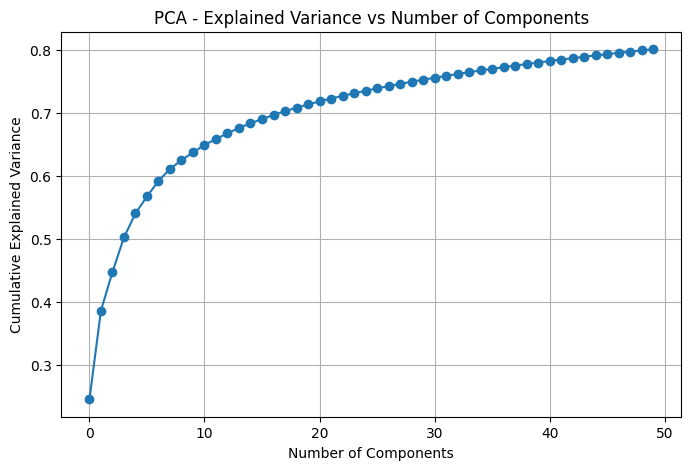

Original shape: (546, 50176)
PCA reduced shape: (546, 50)


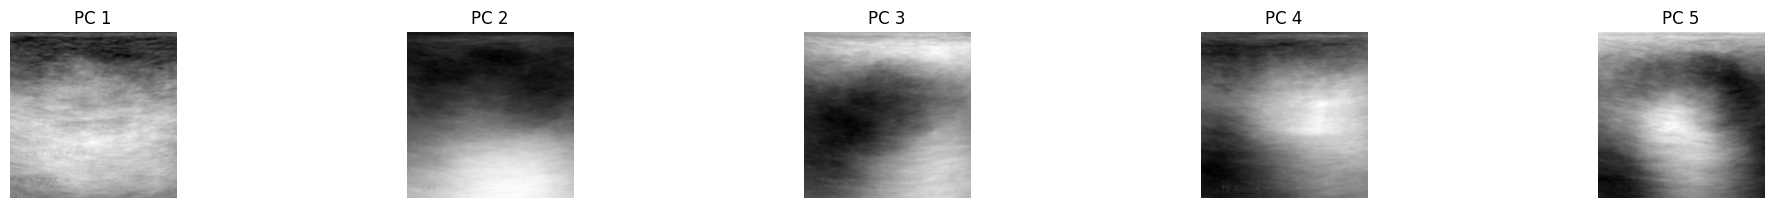

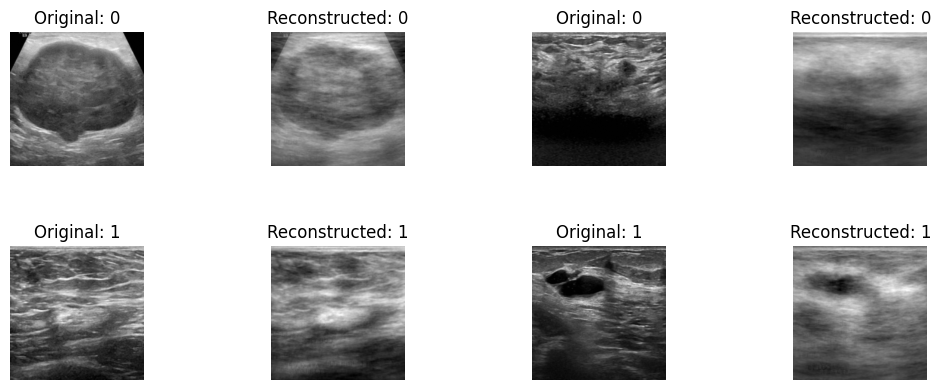

In [22]:
# PCA and visualization
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Apply PCA
# If you apply PCA on the whole data (including the test data) before training the model,
# then you in fact use some information from the test data.
# Thus, you cannot really judge the behaviour of your model using the test data,
# because it is not an unseen data anymore.
n_components = 50
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_std)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

print(f"Original shape: {flattened_images.shape}")
print(f"PCA reduced shape: {principal_components.shape}")

# Plot the first 5 principal components
plt.figure(figsize=(20, 4))
for i in range(5):     
    plt.subplot(2, 5, i + 1)
    component = pca.components_[i].reshape(224, 224)  # Reshape to original image dimensions
    plt.imshow(component, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
# Plot the first 5 images of the training set
# Inverse transform to reconstruct images from PCA
reconstructed = pca.inverse_transform(principal_components)
reconstructed_images = scaler.inverse_transform(reconstructed)
reconstructed_images = reconstructed_images.reshape(x_train.shape)

# Plot 2 images per class: original vs reconstructed
unique_classes = np.unique(y_train)
images_per_class = 2

plt.figure(figsize=(10, 4))  # Bigger images

plot_idx = 1
for class_label in unique_classes:
    # Find indices for this class
    class_indices = np.where(y_train == class_label)[0][:images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(x_train[idx].reshape(224, 224), cmap='gray')
        plt.title(f"Original: {class_label}")
        plt.axis('off')
        plot_idx += 1

        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(reconstructed_images[idx].reshape(224, 224), cmap='gray')
        plt.title(f"Reconstructed: {class_label}")
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

### t-SNE

t-SNE output shape: (546, 2)


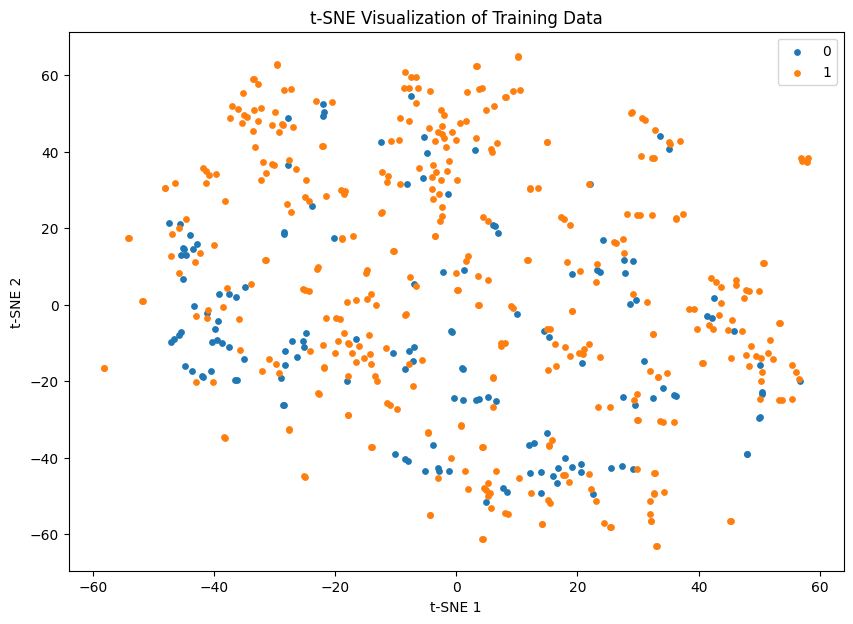

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(flattened_images_std)
print("t-SNE output shape:", X_tsne.shape)

# Plot t-SNE result, colored by class
plt.figure(figsize=(10, 7))
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=class_label, s=15)
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

## Δ. Κλασικοί Αλγόριθμοι Ταξινόμησης

### 1. Logistic Regression

In [26]:
# Logistic regression with LDA features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
# Logistic regression with PCA features
# Fit PCA on training data
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(x_train_std)
X_test_pca = pca.transform(x_test_std)

# Train logistic regression on PCA features
LogisticRegression_pca = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
LogisticRegression_pca.fit(X_train_pca, y_train)

# Predict on test set (PCA features)
y_pred_pca = LogisticRegression_pca.predict(X_test_pca)

# Evaluate
print("Test Accuracy (PCA features):", accuracy_score(y_test, y_pred_pca))
print("\nClassification Report (PCA features):\n", classification_report(y_test, y_pred_pca))

Test Accuracy (PCA features): 0.8461538461538461

Classification Report (PCA features):
               precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.85      0.96      0.90        57

    accuracy                           0.85        78
   macro avg       0.85      0.74      0.77        78
weighted avg       0.85      0.85      0.83        78



C:\Users\vasgk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [29]:
# Grid search for best hyperparameters in Logistic Regression with PCA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100,1000,2500, 5000]
}

# Initialize Logistic Regression (no need to set random_state for grid search)
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 160 candidates, totalling 480 fits
Best parameters found: {'C': np.float64(0.0001), 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation score: 0.7655677655677655
Test Accuracy: 0.8461538461538461

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.85      0.96      0.90        57

    accuracy                           0.85        78
   macro avg       0.85      0.74      0.77        78
weighted avg       0.85      0.85      0.83        78



C:\Users\vasgk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.85      0.96      0.90        57

    accuracy                           0.85        78
   macro avg       0.85      0.74      0.77        78
weighted avg       0.85      0.85      0.83        78

Accuracy: 0.8462
Precision (macro): 0.8462
Recall (macro): 0.7444
F1 Score (macro): 0.7743


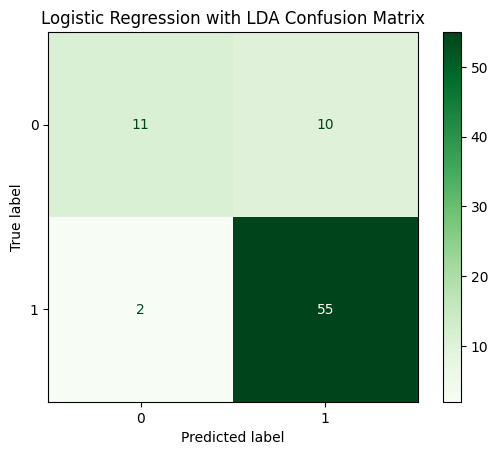

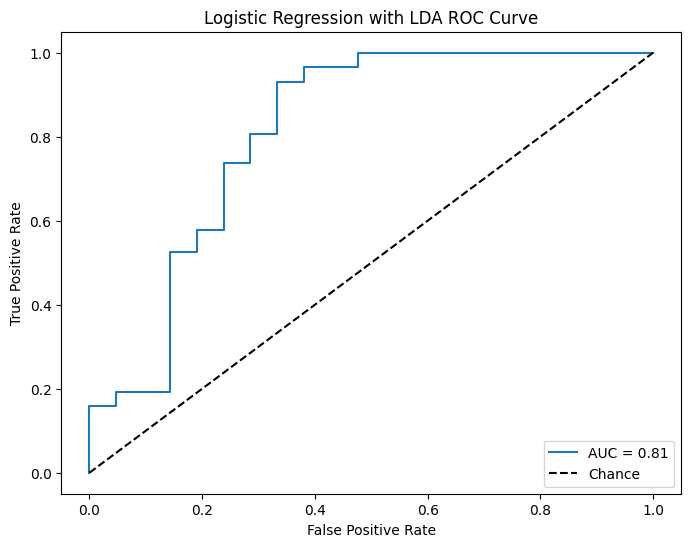

In [31]:
# Assess the model's performance
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def assess_model_performance(clf, X_test, y_test, class_labels=None, title_prefix=""):
    # Predict
    y_pred = clf.predict(X_test)
    if class_labels is None:
        class_labels = np.unique(y_test)

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    # ROC Curve (if possible)
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)

    if y_score is not None:
        # Binary classification: plot only one ROC curve
        if len(class_labels) == 2:
            # y_score may be 1D (decision_function) or 2D (predict_proba)
            if y_score.ndim == 1:
                fpr, tpr, _ = roc_curve(y_test, y_score)
            else:
                fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{title_prefix} ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multiclass case (your original code)
            y_test_bin = label_binarize(y_test, classes=class_labels)
            plt.figure(figsize=(8, 6))
            for i, class_label in enumerate(class_labels):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{title_prefix} ROC Curve - All Classes')

# Assess the model's performance
assess_model_performance(LogisticRegression_pca, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with LDA")

<div class="alert alert-block alert-danger">
ΛΕΕΙ ΚΑΛΟ ΕΙΝΑΙ ΝΑ ΕΧΟΥΜΕ DECISION BOUNDARY ΑΛΛΑ ΤΟ ΠΑΡΑΚΑΤΩ ΕΙΝΑΙ ΓΤΠ, ΝΑ ΔΕΙΣ ΠΩΣ ΝΑ ΒΕΛΤΙΩΘΕΙ
</div>

C:\Users\vasgk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


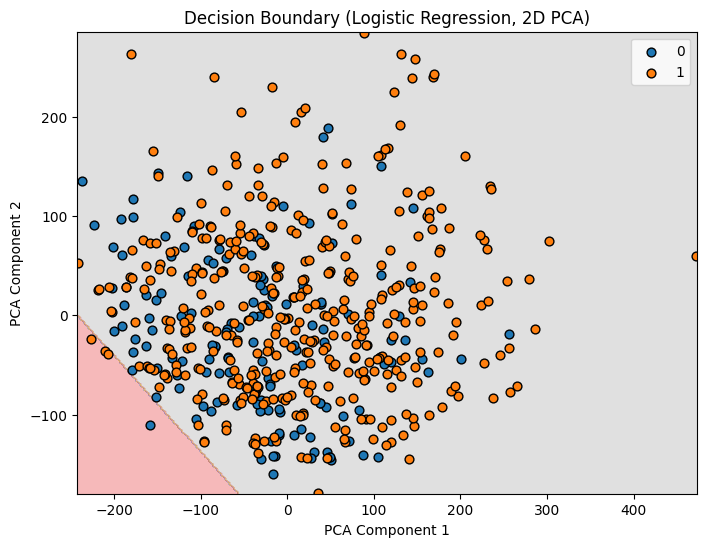

In [28]:
# Plotting decision boundary using the first two PCA components
import numpy as np
import matplotlib.pyplot as plt

# Reduce data to 2D for visualization
X_train_2d = X_train_pca[:, :2]
X_test_2d = X_test_pca[:, :2]

# Retrain classifier on 2D PCA data for visualization
clf_2d = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf_2d.fit(X_train_2d, y_train)

# Create a mesh to plot the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Map class labels to integer indices for contourf
class_labels, Z_int = np.unique(y_train, return_inverse=True)
label_to_int = {label: idx for idx, label in enumerate(class_labels)}
Z_int = np.array([label_to_int[label] for label in Z])
Z_int = Z_int.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_int, alpha=0.3, cmap=plt.cm.Set1)

# Plot training points
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], label=class_label, edgecolor='k', s=40)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (Logistic Regression, 2D PCA)')
plt.legend()
plt.show()

### 2. Support Vector Machines

In [32]:
# Classification SVM with PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_pca)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 0.8076923076923077

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.82      0.95      0.88        57

    accuracy                           0.81        78
   macro avg       0.78      0.69      0.71        78
weighted avg       0.80      0.81      0.79        78



In [33]:
# Grid search for best hyperparameters in SVM with PCA features

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7857142857142857
SVM Test Accuracy: 0.782051282051282

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56        21
           1       0.83      0.88      0.85        57

    accuracy                           0.78        78
   macro avg       0.72      0.70      0.71        78
weighted avg       0.77      0.78      0.78        78




Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.82      0.95      0.88        57

    accuracy                           0.81        78
   macro avg       0.78      0.69      0.71        78
weighted avg       0.80      0.81      0.79        78

Accuracy: 0.8077
Precision (macro): 0.7841
Recall (macro): 0.6880
F1 Score (macro): 0.7118


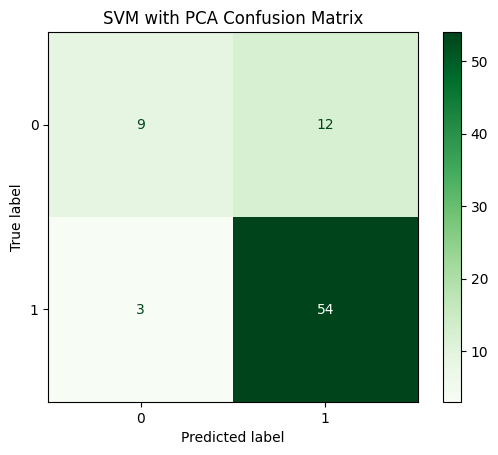

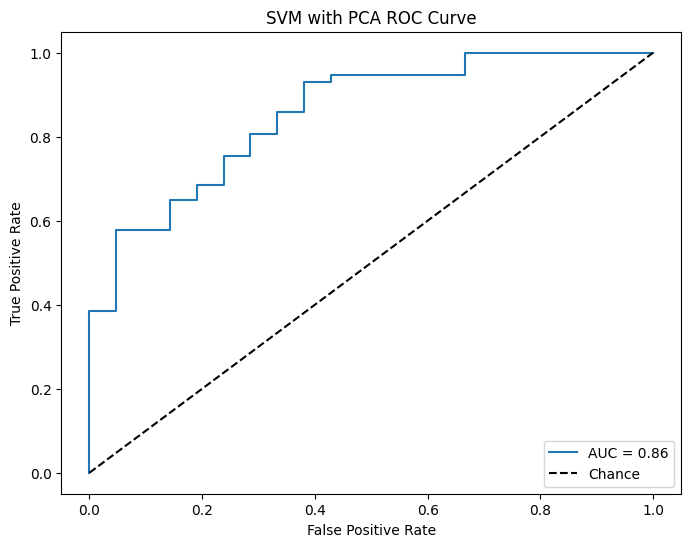

In [34]:
assess_model_performance(svm_clf, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="SVM with PCA")


### 3. k-Κοντινότεροι Γείτονες (k-NN)

In [35]:
# KNN classification with PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.782051282051282

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.59        21
           1       0.84      0.86      0.85        57

    accuracy                           0.78        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.78      0.78      0.78        78



In [37]:
# Grid search for best hyperparameters in KNN with PCA features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)


# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Best parameters found: {'metric': 'manhattan', 'n_neighbors': np.int64(9), 'weights': 'distance'}
Best cross-validation score: 0.7838827838827838
KNN Test Accuracy: 0.8205128205128205

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.83      0.95      0.89        57

    accuracy                           0.82        78
   macro avg       0.80      0.71      0.74        78
weighted avg       0.81      0.82      0.81        78




Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.83      0.95      0.89        57

    accuracy                           0.82        78
   macro avg       0.80      0.71      0.74        78
weighted avg       0.81      0.82      0.81        78

Accuracy: 0.8205
Precision (macro): 0.8000
Recall (macro): 0.7118
F1 Score (macro): 0.7367


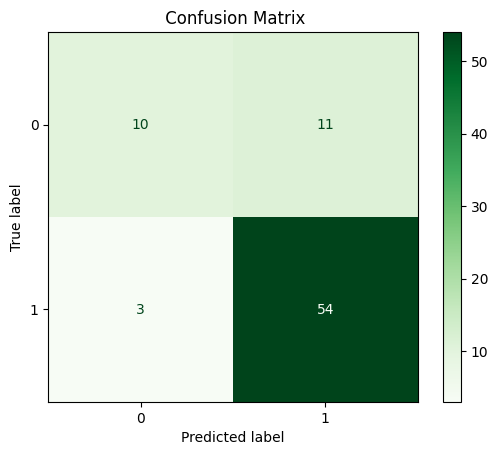

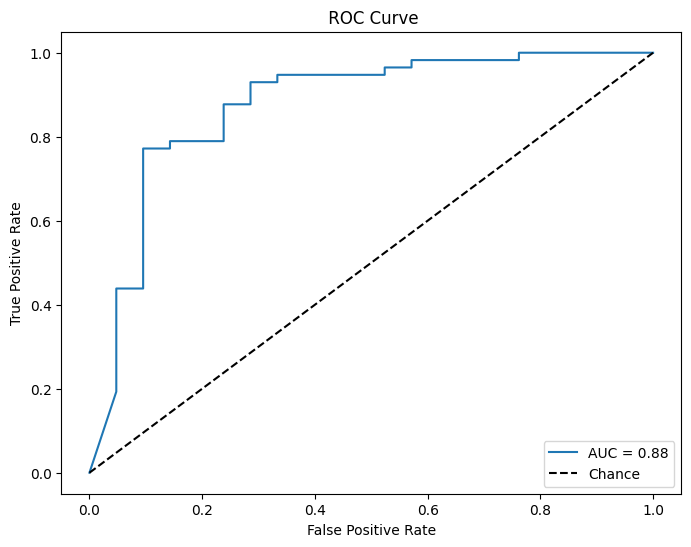

In [42]:
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test)
#assess_model_performance(knn, X_test_pca, y_test)  # Για κάποιο λόγο δεν δουλεύει αν προηγείται grid search


<div class="alert alert-block alert-danger">
ΔΕΝ ΞΕΡΩ ΤΙ ΕΙΝΑΙ ΤΟ ΑΚΟΛΟΥΘΟ 
</div>

In [43]:
#  custom KNN hyperparameter tuning
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_pca, y_train)
    train_score[neighbor]=knn.score(X_train_pca, y_train)
    test_score[neighbor]=knn.score(X_test_pca, y_test)


for key, value in test_score.items():
    if value==max(test_score.values()):
        best_no_neighbors = key
        print(best_no_neighbors)

# https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7

3


In [44]:
# KNN classification with PCA and custom hyperparameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_no_neighbors)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.8717948717948718

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.90      0.93      0.91        57

    accuracy                           0.87        78
   macro avg       0.84      0.82      0.83        78
weighted avg       0.87      0.87      0.87        78



### 4. Naive Bayes

In [45]:
# Naive Bayes classification with PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_pca)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Test Accuracy: 0.782051282051282

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.81      0.91      0.86        57

    accuracy                           0.78        78
   macro avg       0.73      0.67      0.69        78
weighted avg       0.77      0.78      0.77        78



In [46]:
# Grid search for best hyperparameters in Naive Bayes with PCA features

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -50, 10)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'var_smoothing': np.float64(2.782559402207126e-06)}
Best cross-validation score: 0.7655677655677655
Naive Bayes Test Accuracy: 0.782051282051282

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.81      0.91      0.86        57

    accuracy                           0.78        78
   macro avg       0.73      0.67      0.69        78
weighted avg       0.77      0.78      0.77        78




Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.81      0.91      0.86        57

    accuracy                           0.78        78
   macro avg       0.73      0.67      0.69        78
weighted avg       0.77      0.78      0.77        78

Accuracy: 0.7821
Precision (macro): 0.7277
Recall (macro): 0.6704
F1 Score (macro): 0.6869


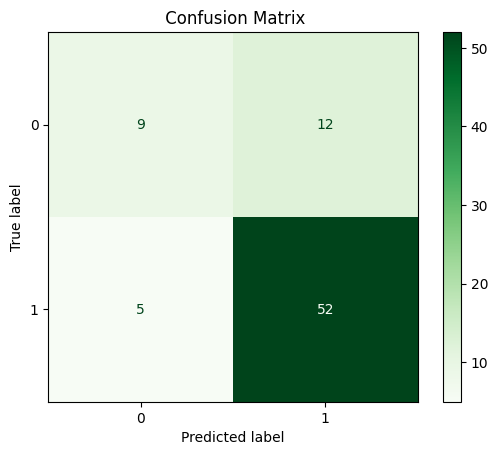

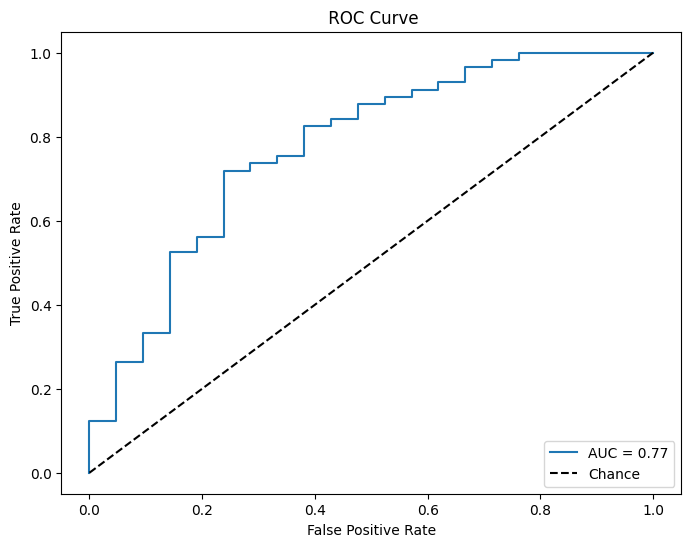

In [47]:
assess_model_performance(nb_clf, X_test_pca, y_test)
